In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

🎨 1. CONFIGURANDO ENTORNO VISUAL...
   Hardware activo: cuda | Tesla T4

📊 2. CARGANDO DATOS (Dataset LFW)...
   Dataset cargado: 3023 imágenes.


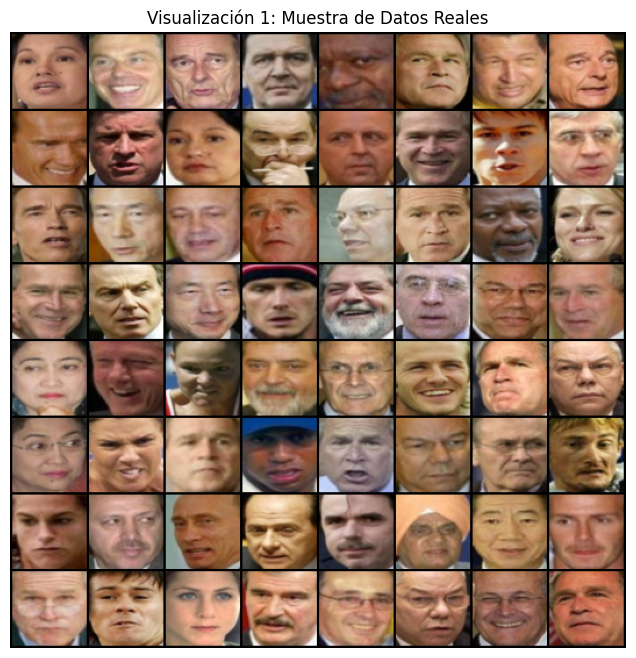

   (Arriba deberías ver los rostros reales del dataset)

🔬 3. EJECUTANDO EXPERIMENTOS RÁPIDOS (Validación)...
   -> Probando: Label Smoothing... [Completo]
   -> Probando: Diff LR... [Completo]
   -> Probando: Big Latent... [Completo]


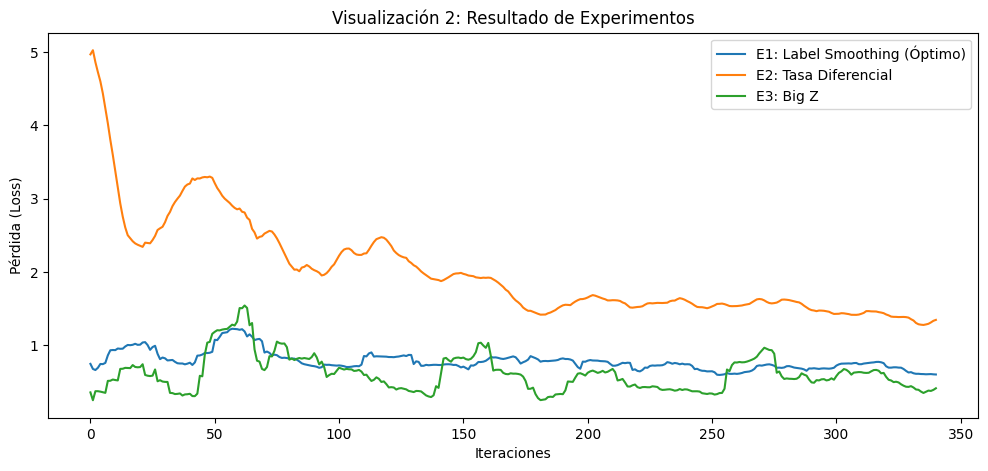

   (La gráfica superior debe mostrar que E1 es la más estable)

🚀 4. INICIANDO ENTRENAMIENTO FINAL (HIGH DEFINITION)...
   Objetivo: 300 épocas. Verás actualizaciones cada 50 épocas.
   >>> Época 0/300 completada. Loss_D: 0.4950


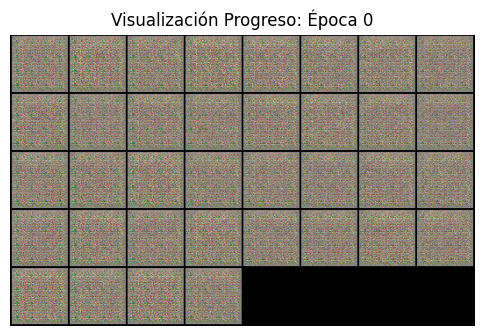

   >>> Época 50/300 completada. Loss_D: 0.8901


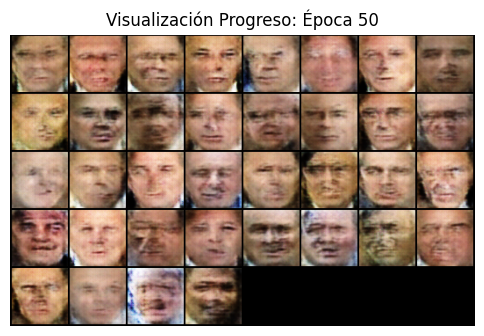

   >>> Época 100/300 completada. Loss_D: 0.5635


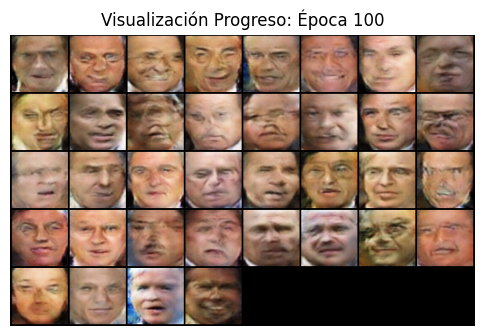

   >>> Época 150/300 completada. Loss_D: 1.6304


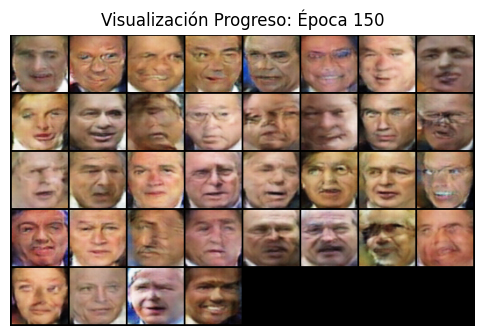

   >>> Época 200/300 completada. Loss_D: 0.3631


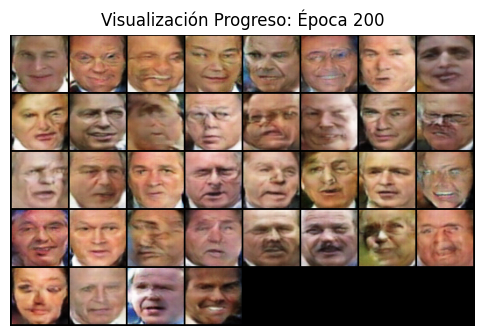

   >>> Época 250/300 completada. Loss_D: 0.4631


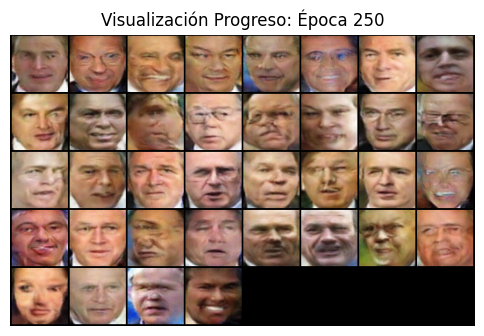

   >>> Época 299/300 completada. Loss_D: 0.3715


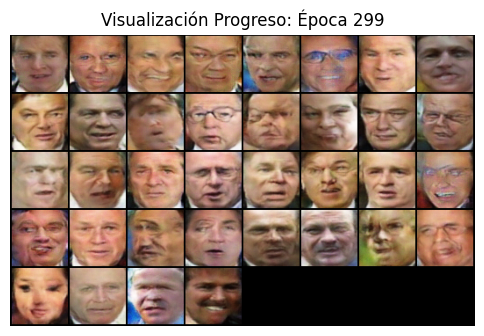

✅ Entrenamiento finalizado. Modelo listo para la Demo.

💻 5. PREPARANDO DEMO (Gradio)...
🔗 COPIA ESTE ENLACE PÚBLICO:
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://6d902242c462480d96.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ==============================================================================
# PROYECTO DCGAN: VISUALIZACIÓN EN TIEMPO REAL (VERSION KAGGLE)
# ==============================================================================

import os
import time

print("🎨 1. CONFIGURANDO ENTORNO VISUAL...")
# Instalación silenciosa de Gradio
try:
    import gradio
except ImportError:
    os.system('pip install -q gradio')
    print("   Gradio instalado.")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_lfw_people
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import gradio as gr

# Hardware Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"   Hardware activo: {device} | {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# ==============================================================================
# A & B. CARGA DE DATOS (Con visualización inicial)
# ==============================================================================
print("\n📊 2. CARGANDO DATOS (Dataset LFW)...")

manualSeed = 999
torch.manual_seed(manualSeed)
nz = 100            
batch_size = 128    
image_size = 64     
nc = 3              

# Descarga a directorio local de Kaggle
lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=None, color=True, 
                              data_home="/kaggle/working/lfw_data")

# Procesamiento
images_raw = lfw_people.images
if images_raw.max() <= 1.0: images_raw = images_raw * 255.0
images_uint8 = images_raw.astype('uint8')

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

X_train = torch.stack([transform(img) for img in images_uint8])
dataset = TensorDataset(X_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"   Dataset cargado: {len(dataset)} imágenes.")

# --- VISUALIZACIÓN 1: MUESTRA DE DATOS REALES ---
# Esto aparecerá en tu consola inmediatamente
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Visualización 1: Muestra de Datos Reales")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show() # <--- ESTO FUERZA LA IMAGEN EN KAGGLE
print("   (Arriba deberías ver los rostros reales del dataset)")

# ==============================================================================
# B. ARQUITECTURA DEL MODELO
# ==============================================================================
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, nz_dim=100): 
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input): return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input): return self.main(input)

# ==============================================================================
# C. EXPERIMENTOS (Visualización de Gráficas)
# ==============================================================================
print("\n🔬 3. EJECUTANDO EXPERIMENTOS RÁPIDOS (Validación)...")
# Reducimos las épocas aquí solo para generar la gráfica rápido y pasar a lo bueno
EPOCHS_EXP = 15 

def run_experiment(exp_name, config):
    nz_dim = config.get('nz', 100)
    smooth = config.get('smooth', False)
    netG = Generator(nz_dim).to(device)
    netD = Discriminator().to(device)
    netG.apply(weights_init); netD.apply(weights_init)
    
    optG = optim.Adam(netG.parameters(), lr=config.get('lr_g', 0.0002), betas=(0.5, 0.999))
    optD = optim.Adam(netD.parameters(), lr=config.get('lr_d', 0.0002), betas=(0.5, 0.999))
    criterion = nn.BCELoss()
    
    losses = []
    print(f"   -> Probando: {exp_name}...", end="")
    
    for epoch in range(EPOCHS_EXP):
        for data in dataloader:
            netD.zero_grad()
            real = data[0].to(device); b_size = real.size(0)
            target = 0.9 if smooth else 1.0
            label = torch.full((b_size,), target, dtype=torch.float, device=device)
            output = netD(real).view(-1)
            errD_real = criterion(output, label); errD_real.backward()
            
            noise = torch.randn(b_size, nz_dim, 1, 1, device=device)
            fake = netG(noise); label.fill_(0.0)
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label); errD_fake.backward()
            optD.step()
            losses.append(errD_real.item() + errD_fake.item())
            
            netG.zero_grad(); label.fill_(1.0)
            output = netD(fake).view(-1)
            errG = criterion(output, label); errG.backward(); optG.step()
    print(" [Completo]")
    return losses

# Ejecución (Sin impresión excesiva, solo gráfica final)
res1 = run_experiment("Label Smoothing", {'smooth': True})
res2 = run_experiment("Diff LR", {'lr_g': 0.0004, 'lr_d': 0.0001})
res3 = run_experiment("Big Latent", {'nz': 128})

# --- VISUALIZACIÓN 2: GRÁFICA COMPARATIVA ---
plt.figure(figsize=(12, 5))
plt.title("Visualización 2: Resultado de Experimentos")
plt.plot(np.convolve(res1, np.ones(20)/20, mode='valid'), label="E1: Label Smoothing (Óptimo)")
plt.plot(np.convolve(res2, np.ones(20)/20, mode='valid'), label="E2: Tasa Diferencial")
plt.plot(np.convolve(res3, np.ones(20)/20, mode='valid'), label="E3: Big Z")
plt.xlabel("Iteraciones")
plt.ylabel("Pérdida (Loss)")
plt.legend()
plt.savefig("/kaggle/working/grafica_analisis.png") # Guardar para informe
plt.show() # <--- Muestra la gráfica en consola
print("   (La gráfica superior debe mostrar que E1 es la más estable)")

# ==============================================================================
# D. ENTRENAMIENTO PRODUCCIÓN (CON VISUALIZACIÓN PASO A PASO)
# ==============================================================================
print("\n🚀 4. INICIANDO ENTRENAMIENTO FINAL (HIGH DEFINITION)...")

final_nz = 100
final_model = Generator(nz_dim=final_nz).to(device); final_model.apply(weights_init)
temp_disc = Discriminator().to(device); temp_disc.apply(weights_init)

optG = optim.Adam(final_model.parameters(), lr=0.0002, betas=(0.5, 0.999))
optD = optim.Adam(temp_disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, final_nz, 1, 1, device=device)

# Aumentamos épocas a 300 para calidad visual alta
NUM_EPOCHS = 300 
VISUALIZATION_INTERVAL = 50 # Veremos rostros cada 50 épocas

print(f"   Objetivo: {NUM_EPOCHS} épocas. Verás actualizaciones cada {VISUALIZATION_INTERVAL} épocas.")

for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(dataloader, 0):
        # Entrenar D (Smoothing)
        temp_disc.zero_grad()
        real = data[0].to(device); b_size = real.size(0)
        label = torch.full((b_size,), 0.9, dtype=torch.float, device=device)
        output = temp_disc(real).view(-1)
        errD_real = criterion(output, label); errD_real.backward()
        
        noise = torch.randn(b_size, final_nz, 1, 1, device=device)
        fake = final_model(noise); label.fill_(0.0)
        output = temp_disc(fake.detach()).view(-1)
        errD_fake = criterion(output, label); errD_fake.backward(); optD.step()

        # Entrenar G
        final_model.zero_grad(); label.fill_(1.0)
        output = temp_disc(fake).view(-1)
        errG = criterion(output, label); errG.backward(); optG.step()
    
    # --- AQUÍ OCURRE LA MAGIA VISUAL EN CONSOLA ---
    # Cada vez que se cumple el intervalo, imprimimos la imagen
    if epoch % VISUALIZATION_INTERVAL == 0 or epoch == NUM_EPOCHS - 1:
        print(f"   >>> Época {epoch}/{NUM_EPOCHS} completada. Loss_D: {errD_real.item()+errD_fake.item():.4f}")
        
        with torch.no_grad():
            fake_viz = final_model(fixed_noise).detach().cpu()
        
        plt.figure(figsize=(6,6)) # Tamaño contenido
        plt.axis("off")
        plt.title(f"Visualización Progreso: Época {epoch}")
        plt.imshow(np.transpose(vutils.make_grid(fake_viz[:36], padding=2, normalize=True), (1,2,0)))
        plt.show() # <--- ¡MUESTRA LOS ROSTROS EN LA CONSOLA!

print("✅ Entrenamiento finalizado. Modelo listo para la Demo.")

# ==============================================================================
# E. INTERFAZ FINAL (Gradio)
# ==============================================================================
print("\n💻 5. PREPARANDO DEMO (Gradio)...")

def generar_web(num, semilla):
    if semilla != -1: torch.manual_seed(int(semilla))
    noise = torch.randn(int(num), final_nz, 1, 1, device=device)
    with torch.no_grad():
        fake = final_model(noise).detach().cpu()
    res = []
    for i in range(fake.size(0)):
        img = (fake[i]*0.5)+0.5
        ndarr = img.mul(255).add_(0.5).clamp_(0,255).permute(1,2,0).to('cpu', torch.uint8).numpy()
        res.append(Image.fromarray(ndarr).resize((256,256), Image.NEAREST))
    return res

summary_text = str(final_model)

with gr.Blocks(title="DCGAN Demo") as demo:
    gr.Markdown("# Generador DCGAN en Kaggle")
    with gr.Tabs():
        with gr.TabItem("Demo"):
            with gr.Row():
                btn = gr.Button("Generar")
                out = gr.Gallery()
            btn.click(generar_web, inputs=[gr.Slider(1,16,4,step=1), gr.Slider(-1,999,-1)], outputs=out)
        with gr.TabItem("Doc Técnica"):
            gr.Code(value=summary_text, language="python")

print("🔗 COPIA ESTE ENLACE PÚBLICO:")
demo.launch(share=True, inline=False, debug=True)
